# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import SignOPTAttack

# Load Data

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [4]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Model

In [5]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 3)),
    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])

In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train

In [7]:
history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
391/391 [==============================] - 8s 13ms/step - loss: 1.4283 - accuracy: 0.4902 - val_loss: 1.0775 - val_accuracy: 0.6195
Epoch 2/10
391/391 [==============================] - 4s 10ms/step - loss: 0.9609 - accuracy: 0.6638 - val_loss: 0.8849 - val_accuracy: 0.6883
Epoch 3/10
391/391 [==============================] - 4s 9ms/step - loss: 0.7711 - accuracy: 0.7330 - val_loss: 0.7983 - val_accuracy: 0.7210
Epoch 4/10
391/391 [==============================] - 4s 9ms/step - loss: 0.6254 - accuracy: 0.7816 - val_loss: 0.7472 - val_accuracy: 0.7442
Epoch 5/10
391/391 [==============================] - 4s 10ms/step - loss: 0.4943 - accuracy: 0.8277 - val_loss: 0.7483 - val_accuracy: 0.7488
Epoch 6/10
391/391 [==============================] - 4s 10ms/step - loss: 0.3687 - accuracy: 0.8715 - val_loss: 0.7969 - val_accuracy: 0.7531
Epoch 7/10
391/391 [==============================] - 4s 10ms/step - loss: 0.2471 - accuracy: 0.9133 - val_loss: 0.9139 - val_accuracy: 0.7436
E

# Attack

In [8]:
art_model = TensorFlowV2Classifier(model=model, nb_classes=10, input_shape=(32, 32, 3), clip_values=(0, 1))

In [10]:
sign_opt_attack = SignOPTAttack(estimator=art_model, targeted=False, max_iter=100, query_limit=2000)

In [11]:
adv_test = sign_opt_attack.generate(x=x_test[:16])

# Results

In [12]:
safe_preds = np.argmax(art_model.predict(x_test[:16]), axis=1)

In [13]:
safe_preds

array([3, 8, 8, 8, 6, 6, 3, 6, 3, 1, 0, 9, 5, 7, 9, 8])

In [14]:
y_test = np.argmax(y_test[:16], axis=1)

In [15]:
safe_model_scores = {
    'ACC': accuracy_score(y_test, safe_preds),
    'PREC': precision_score(y_test, safe_preds, average='weighted'),
    'REC': recall_score(y_test, safe_preds, average='weighted'),
    'F1': f1_score(y_test, safe_preds, average='weighted')
}

In [16]:
safe_model_scores

{'ACC': 0.875,
 'PREC': 0.9114583333333333,
 'REC': 0.875,
 'F1': 0.8648809523809524}

In [17]:
adv_preds = np.argmax(art_model.predict(adv_test), axis=1)

In [18]:
adv_model_scores = {
    'ACC': accuracy_score(y_test, adv_preds),
    'PREC': precision_score(y_test, adv_preds, average='weighted'),
    'REC': recall_score(y_test, adv_preds, average='weighted'),
    'F1': f1_score(y_test, adv_preds, average='weighted')
}

/home/alper/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alper/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
adv_model_scores

{'ACC': 0.375,
 'PREC': 0.3177083333333333,
 'REC': 0.375,
 'F1': 0.3410714285714286}

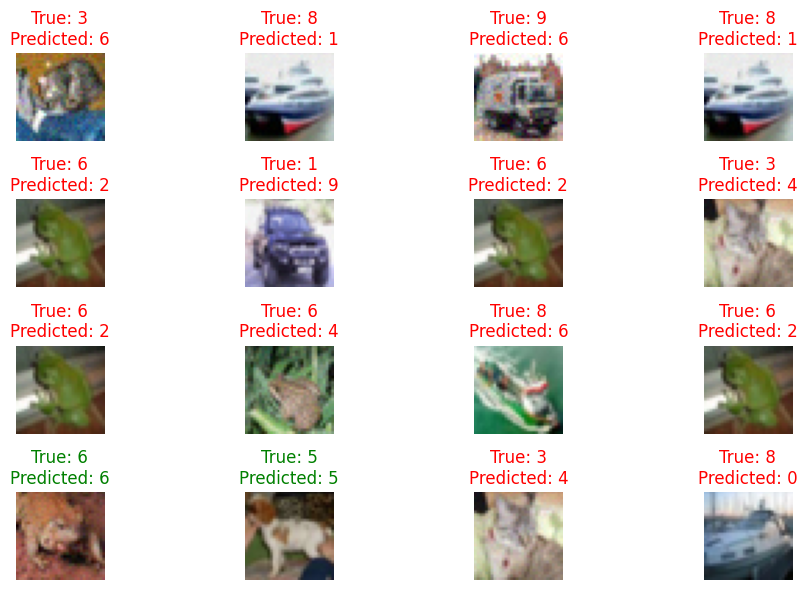

In [20]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 6))
random_index = np.random.randint(0, len(adv_test), 16)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(adv_test[random_index[i]], cmap='gray')
    ax.axis('off')

    if y_test[random_index[i]] == adv_preds[random_index[i]]:
        color = 'green'
    else:
        color = 'red'

    ax.set_title(
        f'True: {y_test[random_index[i]]}\nPredicted: {adv_preds[random_index[i]]}',
        color=color
    )

plt.tight_layout()
plt.show()